AnimeChanStyle has been loaded!


Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Using the seed 1555363155
(AnimeChan Style:1), (the land of the frogs, mail art, painted by zdzislaw beksinski:1), (a beautiful azure landscape:0.5)


  0%|          | 0/20 [00:00<?, ?it/s]

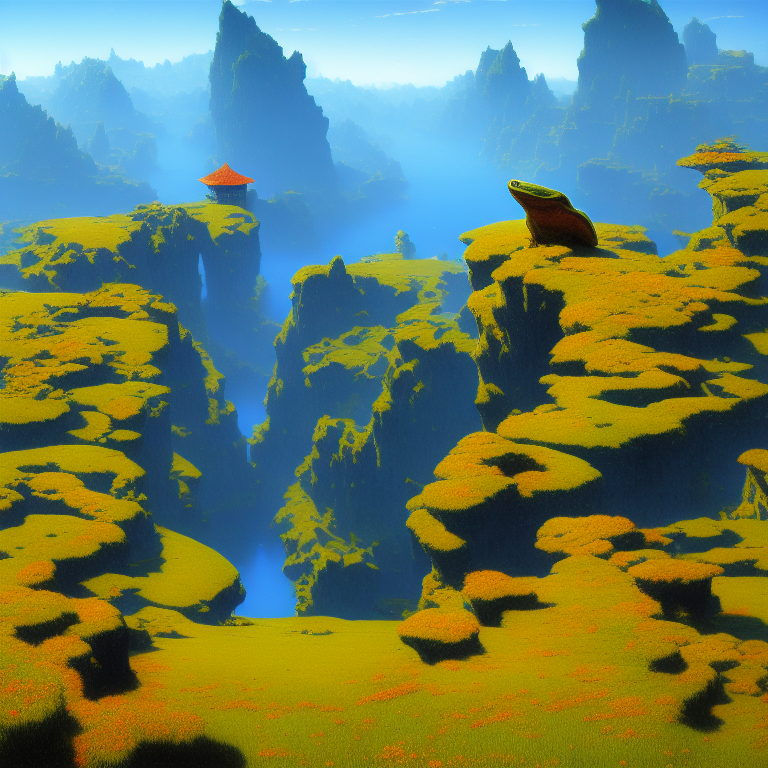

In [1]:
#install
#@markdown
#@markdown If the code to the left is too large or annoying, double click on this text to hide it<br/>See above cell for model descriptions and settings explanation <br />
#@markdown ### <b>Model Choice </b>
model = "Stable Diffusion 1.5" #@param ["Stable Diffusion 1.4","Stable Diffusion 1.5","Stable Diffusion 2.0 (512)","Stable Diffusion 2.0 (768)","Stable Diffusion 2.1 (512)","Stable Diffusion 2.1 (768)","Dreamlike Diffusion","Openjourney","Openjourney V2 Beta","seek.art_MEGA","Sygil Diffusion","Analog Diffusion","Dreamlike Photoreal","Anything v3.0","Anything v4.0","Waifu Diffusion 1.4 (Epoch 1 Test Version)","Plat Diffusion (Waifu 1.4 finetune)","AnimeChanStyle","Inkpunk Diffusion","Vivid Watercolors","Future Diffusion","Gigafractal Diffusion (768)","Van Gogh Diffusion","Corporate Memphis","Pokemon Diffusion","Robo Diffusion","Classic Animation Diffusion","Modern Animation Diffusion","Ghibli Diffusion","Furry Diffusion"] {type:"string"}

add_automatic_keyword = True #@param {type: "boolean"}
download_a_collection_of_text_inversion_embeddings_and_load_them = False #@param {type: "boolean"}
#@markdown

try:
  import torch
  from src import SimpleStable
except ImportError as e:
  print("Installing required libraries...")
  !pip3 install torch torchvision torchaudio diffusers transformers accelerate scipy omegaconf pillow tqdm requests huggingface_hub ipywidgets lark safetensors --extra-index-url https://download.pytorch.org/whl/cu116 > /dev/null
  %cd /content/
  !git clone https://github.com/cadaeix/simplest-stable.git > /dev/null
  outputs_path = "/content/images/"
  !mkdir -p $outputs_path
  print(f"Outputs will be saved to {outputs_path}.")
  embeds_path = None

should_load_embeds = False
attention_slicing = False

%cd /content/simplest-stable/
import sys
sys.path.append(".")
from IPython.display import display, clear_output
from datetime import datetime
import os
import random
import math
import random
import torch
from tqdm import tqdm
import json
import PIL
import numpy as np
from PIL import Image
from src import SimpleStable, utils, SimpleStableDiffusionPipeline
import glob
%cd /content/

if download_a_collection_of_text_inversion_embeddings_and_load_them:
  embeds_path = "/content/embeds/"
  if not os.path.exists(embeds_path):
    !mkdir -p $embeds_path
    %cd /content/embeds
    !wget https://huggingface.co/cadaeic/v2_dreamink/resolve/main/v2_dreamink.pt
    !wget -O 'v1_bad_prompt.pt' https://huggingface.co/datasets/Nerfgun3/bad_prompt/resolve/main/bad_prompt_version2.pt
    !wget -O 'v2_knollingcase.pt' https://huggingface.co/ProGamerGov/knollingcase-embeddings-sd-v2-0/resolve/main/kc32-v4-5000.pt
    !wget -O 'v2_PhotoHelper.pt' https://huggingface.co/spaablauw/PhotoHelper/resolve/main/PhotoHelper.pt
    !wget -O 'v2_CinemaHelper.pt' https://huggingface.co/spaablauw/CinemaHelper/resolve/main/CinemaHelper.pt
    !wget -O 'v2_VintageHelper.pt' https://huggingface.co/spaablauw/VintageHelper/resolve/main/VintageHelper.pt
    !wget -O 'v2_ActionHelper.pt' https://huggingface.co/spaablauw/ActionHelper/resolve/main/ActionHelper.pt
    !wget -O 'v2_glitch.pt' https://huggingface.co/joachimsallstrom/Glitch-Embedding/resolve/main/glitch.pt
    !wget -O 'v1_midj_anthro.pt' https://huggingface.co/crumb/midjourney-textual-inversions/resolve/main/midj-anthro.pt
    !wget -O 'v1_midj_portrait.pt' https://huggingface.co/crumb/midjourney-textual-inversions/resolve/main/midj-portrait.pt
    !wget -O 'v1_midj_strong.pt' https://huggingface.co/crumb/midjourney-textual-inversions/resolve/main/midj-strong.pt
    !wget -O 'v2_wrong.bin' https://huggingface.co/minimaxir/wrong_embedding_sd_2_0/resolve/main/learned_embeds.bin
    !wget -O 'v2_laxpeint.pt' https://huggingface.co/EldritchAdam/laxpeint/resolve/main/laxpeintV2.pt
    !wget -O 'v2_classipeint.pt' https://huggingface.co/EldritchAdam/classipeint/blob/main/classipeint.pt
    !wget -O 'v2_AnimeScreencap.pt' https://huggingface.co/Conflictx/AnimeScreencap/resolve/main/AnimeScreenCap.pt
    !wget -O 'v2_DoubleExposure.pt' https://huggingface.co/joachimsallstrom/Double-Exposure-Embedding/resolve/main/dblx.pt
    !wget -O 'v1_charturner' https://huggingface.co/Mousewrites/charTurner/resolve/main/charTurner.pt
  should_load_embeds = True

try:
  outputs_folder
  if not os.path.exists(outputs_folder):
      os.mkdirs(outputs_folder)
  session_folder = outputs_folder
except NameError as e:
  outputs_path = "images/"
  if not os.path.exists(outputs_path):
      os.mkdir(outputs_path)
      
  session_folder = os.path.join(outputs_path, datetime.now().strftime("%Y_%m_%d"))
  if not os.path.exists(session_folder):
      os.mkdir(session_folder)

try:
  custom_models_folder
  custom_models_path = custom_models_folder if os.path.exists(custom_models_folder) else None
except NameError as e:
  custom_models_path = None

try:
  custom_embeddings_folder
  embeddings_path = custom_embeddings_folder if os.path.exists(custom_embeddings_folder) else None
except NameError as e:
  embeddings_path = None

clear_output(wait=False)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


#@markdown ### <b>Image Generation</b><br>
#@markdown See previous cell for setting explanations
prompt = "(the land of the frogs, \u003Cstyle>, painted by zdzislaw beksinski:1), (a beautiful \u003Ccolor> landscape:0.5)" #@param{type:"string"}
negative = "" #@param{type: 'string'}
resolution = "Square 768x768 (good for 768 models)" #@param ["Custom (Select this and put width and height below)", "Square 512x512 (default, good for most models)", "Landscape 768x512", "Portrait 512x768", "Square 768x768 (good for 768 models)", "Landscape 1152x768 (does not work on free colab)", "Portrait 768x1152 (does not work on free colab)"] {type:"string"}

#width_height = [768,512] #@param{type: 'raw'}
#@markdown <br>
#@markdown <b>Advanced Settings</b>
width_height_if_custom_is_selected = [576, 704] #@param{type: 'raw'}
steps = 20 #@param {type:"integer"}
samples_per_batch = 1
number_of_images = 1 #@param {type:"integer"}
seed = -1 #@param {type:"integer"}
sampler = "Euler a" #@param ["Euler a", "Euler", "KLMS", "DPMSolver++ (2S) (has issues with img2img)", "DPMSolver++ (2M)"] {type:"string"}
batch_name = ""
batch_name = batch_name + datetime.now().strftime("%H:%M:%S")
guidance_scale = 7 #@param {type:"slider", min:0, max:20, step:0.5}
ddim_eta = 0.0
zoom = False
tiling = False #@param {type: "boolean"}
#@markdown If `tiling` results look poor, double the amount of steps from non-tiling.
#@markdown <br>
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>Init image</b><br>
init_image_or_folder = "" #@param {type:"string"}
denoising_strength = 0.9 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>Upscaling</b><br>

upscale_results = False #@param {type: 'boolean'}
# detailing = 1 #@param {type:"slider", min:1, max:4, step:1}
upscale_strength = 0.2 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
######

res_dict = {"Square 512x512 (default, good for most models)": [512,512],
            "Landscape 768x512": [768,512],
            "Portrait 512x768": [512,768],
            "Square 768x768 (good for 768 models)": [768,768],
            "Landscape 1152x768 (does not work on free colab)": [1152,768],
            "Portrait 768x1152 (does not work on free colab)":[768,1152]}
width, height = width_height_if_custom_is_selected if resolution == "Custom (Select this and put width and height below)" else res_dict[resolution]

opt = {
    "model_name" : model,
    "vae_name" : "",
    "eta" : 0.0,
    "steps" : steps,
    "fixed_code" : True,
    "init_img" : init_image_or_folder if init_image_or_folder != "" else None,
    "n_iter" : 1,
    "batches" : number_of_images, #how many
    "outdir" : "",
    "precision" : 'autocast',
    "prompt" : prompt,
    "negative" : negative,
    "sampler" : sampler,
    "tiling" : tiling,
    "scale" : guidance_scale,
    "seed" : seed,
    "strength" : denoising_strength if init_image_or_folder != "" else None, # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
    "H" : height - height % 64,
    "W" : width - width % 64,
    #upscale stuff
    "passes" : 1,
    "upscale": upscale_results,
    "gobig_overlap" : 128,
    #"detail_steps" : steps*detailing,
    "upscale_strength" : upscale_strength,
    "detail_scale" : 10,
    "add_keyword": add_automatic_keyword,
    "outputs_folder": session_folder
    }

recreate = False
try:
  pipe
  recreate = model_name != opt["model_name"]
except NameError as e:
  pipe = None
  recreate = True
model_name = opt["model_name"]

if should_load_embeds:
  embeddings_list = glob.glob("/content/embeds/*")
else:
  embeddings_list = []

pipe = SimpleStable.main(opt, pipe, recreate, embeddings_list)

# from google.colab import output
# output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')